"""
Proyecto de Predicción de Fallos en Equipos Industriales (Versión Mejorada)
Autor: Gonzalo Cisterna Salinas
Descripción: Este notebook contiene un flujo completo de ciencia de datos para la predicción
de fallas en equipos industriales, usando Python y librerías como pandas, numpy, scikit-learn.
"""

In [1]:
# =================================
# CELDA 1: IMPORTACIONES
# =================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Para ver las gráficas directamente en el Notebook
%matplotlib inline

In [7]:
# ===============================
# CELDA 2: CARGA DEL DATASET
# ===============================

# Comentario: Leemos el archivo CSV que contiene los datos. Ajusta la ruta si es necesario.
# Asegúrate de tener el archivo 'machine_failure_data.csv' en la misma carpeta que este notebook
# o en la ruta adecuada.
df = pd.read_csv('machine_failure_data.csv')

# Comentario: Vemos las primeras filas para confirmar la lectura correcta de datos.
df.head()

,temp_sensor,vibration_sensor,pressure_sensor,hours_since_maintenance,machine_type,failure
0,79.967142,4.185806,105.224294,891,TypeA,0
1,73.617357,4.633401,104.249854,497,TypeB,0
2,81.476885,4.283143,85.952202,959,TypeC,0
3,90.230299,5.132502,108.693763,875,TypeB,0
4,72.658466,6.436614,77.648760,963,TypeC,1


In [8]:
# ===============================
# CELDA 3: EXPLORACIÓN INICIAL DE DATOS
# ===============================

# Comentario: Observamos la dimensión (filas x columnas).
print("Dimensiones del dataset:", df.shape)

# Comentario: Vemos el tipo de cada columna, número de valores no nulos, etc.
df.info()

# Comentario: Descripción estadística de variables numéricas (promedio, desviación, etc.).
df.describe()

# Comentario: Checamos si hay valores nulos en cada columna.
df.isnull().sum()

Dimensiones del dataset: (10000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temp_sensor              10000 non-null  float64
 1   vibration_sensor         10000 non-null  float64
 2   pressure_sensor          10000 non-null  float64
 3   hours_since_maintenance  10000 non-null  int64  
 4   machine_type             10000 non-null  object 
 5   failure                  10000 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 468.9+ KB


temp_sensor                0
vibration_sensor           0
pressure_sensor            0
hours_since_maintenance    0
machine_type               0
failure                    0
dtype: int64

In [4]:
# ===============================
# CELDA 4: REVISIÓN DE NULOS Y LIMPIEZA
# ===============================

# Comentario: Revisamos si hay valores nulos en cada columna del dataset
print("Valores nulos por columna:")
print(df.isnull().sum())

# Comentario: Si hubiera valores nulos, los manejaríamos. Por ejemplo:
# 1. Eliminar filas con nulos:
# df.dropna(inplace=True)

# 2. Imputar valores (reemplazar nulos con un valor específico, como la media):
# df['columna'].fillna(df['columna'].mean(), inplace=True)

# En este caso, el análisis previo muestra que no hay valores nulos,
# por lo que no es necesario realizar limpieza adicional.

# Comentario: Confirmamos que no hay duplicados en el dataset
duplicados = df.duplicated().sum()
print(f"Filas duplicadas en el dataset: {duplicados}")

# Si hubiera duplicados, podríamos eliminarlos:
# df.drop_duplicates(inplace=True)

# Comentario: A partir de aquí, los datos están listos para el análisis exploratorio adicional.


Valores nulos por columna:
temp_sensor                0
vibration_sensor           0
pressure_sensor            0
hours_since_maintenance    0
machine_type               0
failure                    0
dtype: int64
Filas duplicadas en el dataset: 0


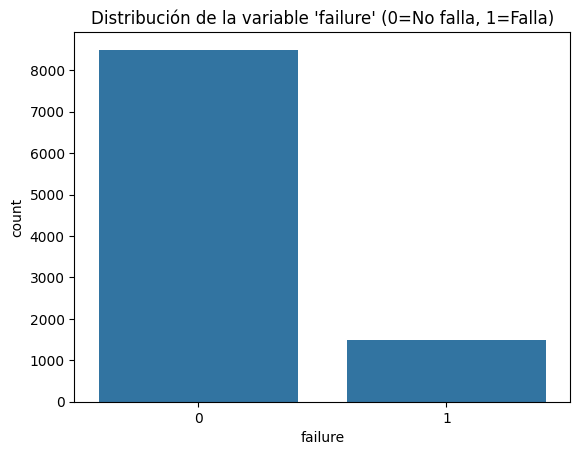

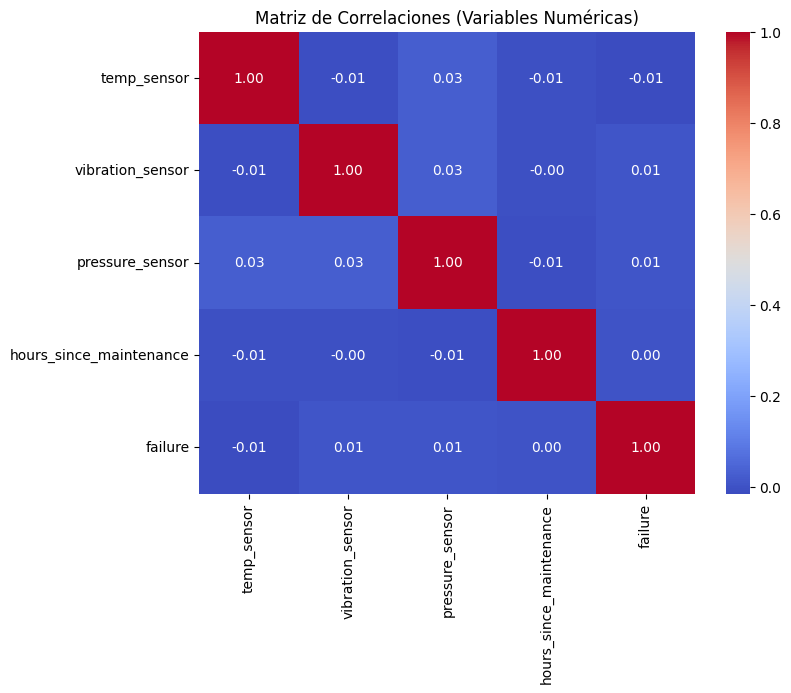

In [8]:
# ===============================
# CELDA 5: ANÁLISIS EXPLORATORIO ADICIONAL
# ===============================

# Distribución de la variable objetivo (failure)
sns.countplot(data=df, x='failure')
plt.title("Distribución de la variable 'failure' (0=No falla, 1=Falla)")
plt.show()

# Filtrar solo columnas numéricas para calcular la matriz de correlación
df_numeric = df.select_dtypes(include=['float64', 'int64'])  # Excluir columnas categóricas

# Mapa de calor de correlación (para variables numéricas)
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlaciones (Variables Numéricas)")
plt.show()

In [10]:
# ===============================
# CELDA 6: SELECCIÓN DE CARACTERÍSTICAS (FEATURES) Y VARIABLE OBJETIVO (TARGET)
# ===============================

# Comentario: Asumimos que la columna 'failure' es nuestra variable objetivo (0 o 1)
y = df['failure']  # Variable objetivo

# Comentario: Eliminamos la columna 'failure' y otras que no sean relevantes para los modelos
X = df.drop('failure', axis=1)

# Comentario: Verificamos si hay columnas categóricas y aplicamos One-Hot Encoding si es necesario
# Esto convierte columnas como 'machine_type' en variables numéricas binarias
X = pd.get_dummies(X, drop_first=True)  # drop_first=True elimina una columna dummy redundante

# Comentario: Revisamos las dimensiones finales de las características y la variable objetivo
print("Dimensiones de X (características):", X.shape)
print("Dimensiones de y (variable objetivo):", y.shape)


Dimensiones de X (características): (10000, 6)
Dimensiones de y (variable objetivo): (10000,)


In [11]:
# ===============================
# CELDA 7: DIVISIÓN ENTRENAMIENTO/PRUEBA
# ===============================

# Comentario: Dividimos los datos en entrenamiento (80%) y prueba (20%)
# La semilla (random_state=42) asegura la reproducibilidad de los resultados
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% de los datos se usan para prueba
    random_state=42       # Semilla para reproducibilidad
)

# Comentario: Verificamos las dimensiones de los conjuntos de entrenamiento y prueba
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

# Comentario: Observamos una muestra de los datos de entrenamiento para confirmar la división
print("Primeras filas de X_train:")
print(X_train.head())


Tamaño de X_train: (8000, 6)
Tamaño de X_test: (2000, 6)
Tamaño de y_train: (8000,)
Tamaño de y_test: (2000,)
Primeras filas de X_train:
      temp_sensor  vibration_sensor  pressure_sensor  hours_since_maintenance  \
9254    77.190716          7.894852       107.748780                      749   
1561    67.527883          3.628469       122.594439                      419   
1670    72.610679          3.063958       107.551183                      380   
6087    59.521984          5.289295        80.924648                       39   
6669    82.026600          4.773130       137.240166                      708   

      machine_type_TypeB  machine_type_TypeC  
9254               False                True  
1561               False               False  
1670               False               False  
6087               False                True  
6669               False               False  


In [12]:
# ===============================
# CELDA 8: ESCALADO DE CARACTERÍSTICAS
# ===============================

# Comentario: Muchos modelos funcionan mejor si las características tienen escalas similares.
# Usamos StandardScaler para escalar las características.

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con los datos de entrenamiento
scaler.fit(X_train)

# Transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Comentario: Verificamos cómo lucen los datos escalados (primera fila del conjunto de entrenamiento)
print("Primera fila de X_train (original):", X_train.iloc[0].values)
print("Primera fila de X_train (escalada):", X_train_scaled[0])


Primera fila de X_train (original): [np.float64(77.19071562537668) np.float64(7.894851984708614)
 np.float64(107.74878036968752) np.int64(749) np.False_ np.True_]
Primera fila de X_train (escalada): [ 0.2156595   2.3982164   0.52788703  0.86760059 -0.7117523   1.43257465]


In [3]:
# ===============================
# CELDA 9: MODELO 1 - REGRESIÓN LOGÍSTICA
# ===============================

# Comentario: Entrenamos un modelo de Regresión Logística usando los datos escalados
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear una instancia del modelo de Regresión Logística
log_model = LogisticRegression(random_state=42)

# Entrenar el modelo con los datos de entrenamiento escalados
log_model.fit(X_train_scaled, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_log = log_model.predict(X_test_scaled)

# ===============================
# EVALUACIÓN DEL MODELO
# ===============================

# Calcular la precisión del modelo
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Precisión del modelo (Regresión Logística): {accuracy_log:.4f}")

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación (Regresión Logística):\n")
print(classification_report(y_test, y_pred_log))

# Mostrar la matriz de confusión
print("\nMatriz de Confusión (Regresión Logística):\n")
print(confusion_matrix(y_test, y_pred_log))


NameError: name 'X_train_scaled' is not defined